
# A Data-Driven Approach for Predicting Hourly Energy Consumption   (ITALY)






**This notebook presents an analysis and predictive model for forecasting hourly energy consumption based on historical data. We explore the seasonal patterns, the effects**

### Data Exploration

**We start by loading the dataset and performing initial exploratory data analysis (EDA). This helps us understand the data structure, distribution of energy consumption, and missing values.**

#### Loading Data

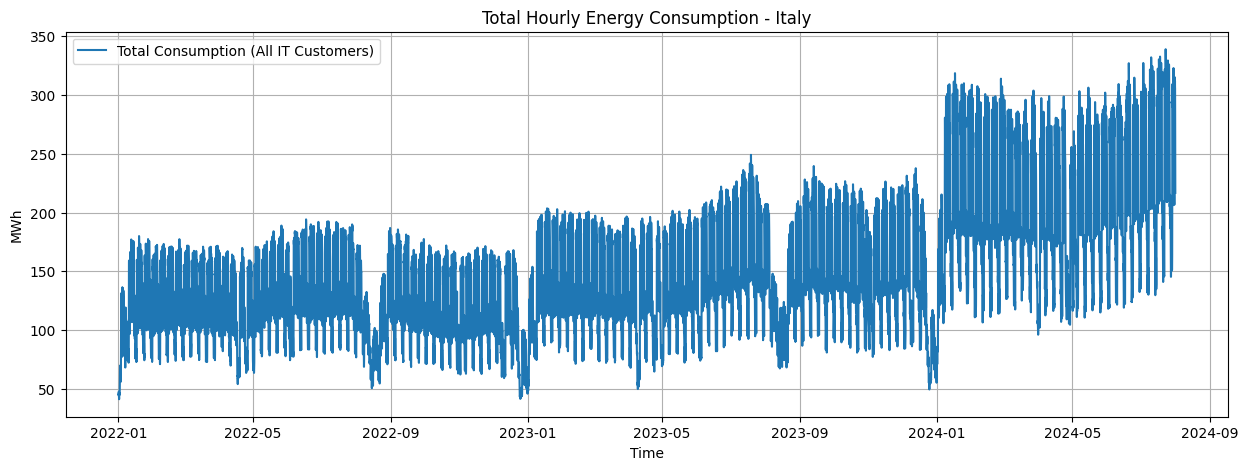

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Load Data
df = pd.read_csv('/kaggle/input/energy-a/historical_metering_data_IT_full_features.csv', parse_dates=['DATETIME'])
df = df.sort_values('DATETIME')
df.set_index('DATETIME', inplace=True)

# Sum consumption across all customers
customer_cols = [col for col in df.columns if col.startswith('VALUEMWHMETERINGDATA_customerIT_')]
df['total_consumption'] = df[customer_cols].sum(axis=1)


# Fill small gaps (if needed)
df['total_consumption'] = df['total_consumption'].interpolate(method='time')

# Plot
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['total_consumption'], label='Total Consumption (All IT Customers)')
plt.title('Total Hourly Energy Consumption - Italy')
plt.xlabel('Time')
plt.ylabel('MWh')
plt.grid()
plt.legend()
plt.show()


In [3]:
print(df.index)



DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 01:00:00',
               '2022-01-01 02:00:00', '2022-01-01 03:00:00',
               '2022-01-01 04:00:00', '2022-01-01 05:00:00',
               '2022-01-01 06:00:00', '2022-01-01 07:00:00',
               '2022-01-01 08:00:00', '2022-01-01 09:00:00',
               ...
               '2024-07-31 14:00:00', '2024-07-31 15:00:00',
               '2024-07-31 16:00:00', '2024-07-31 17:00:00',
               '2024-07-31 18:00:00', '2024-07-31 19:00:00',
               '2024-07-31 20:00:00', '2024-07-31 21:00:00',
               '2024-07-31 22:00:00', '2024-07-31 23:00:00'],
              dtype='datetime64[ns]', name='DATETIME', length=22629, freq=None)


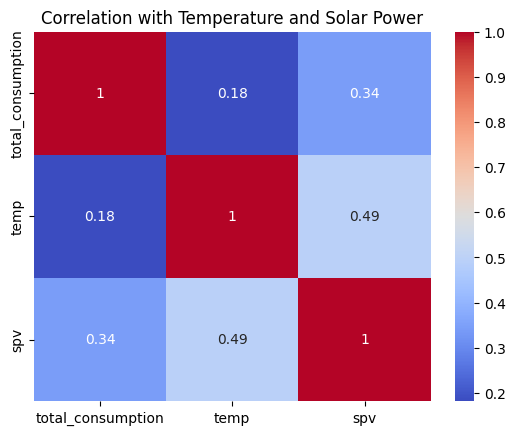

In [4]:
# Correlation
sns.heatmap(df[['total_consumption', 'temp', 'spv']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation with Temperature and Solar Power")
plt.show()



The dataset consists of historical energy consumption data for multiple customers in Italy. Key features include:
- **Hourly energy consumption data** for each customer (e.g., `VALUEMWHMETERINGDATA_customerIT_1`, `VALUEMWHMETERINGDATA_customerIT_2`).
- **External features** such as temperature (`temp`), solar power (`spv`), and holiday indicators (`holiday`).
- **Datetime** information at an hourly granularity.

                                                          

<ipython-input-5-4835ca13209c>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df['total_consumption'].resample('H').mean()


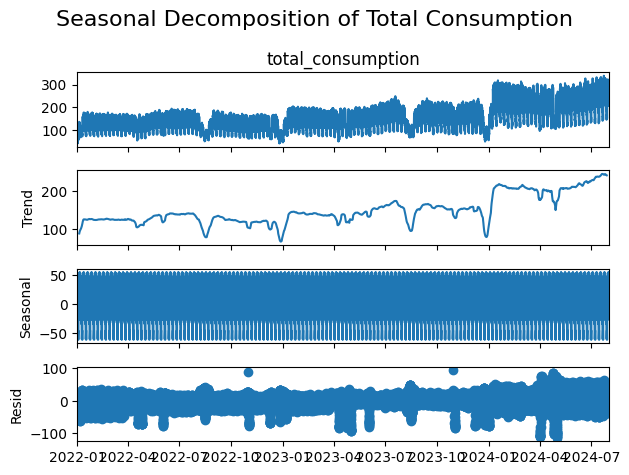

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure datetime is index and data is hourly
df_hourly = df['total_consumption'].resample('H').mean()

# Decompose into Trend, Seasonality, Residual
result = seasonal_decompose(df_hourly.dropna(), model='additive', period=24*7)  # weekly seasonality

result.plot()
plt.suptitle("Seasonal Decomposition of Total Consumption", fontsize=16)
plt.tight_layout()
plt.show()


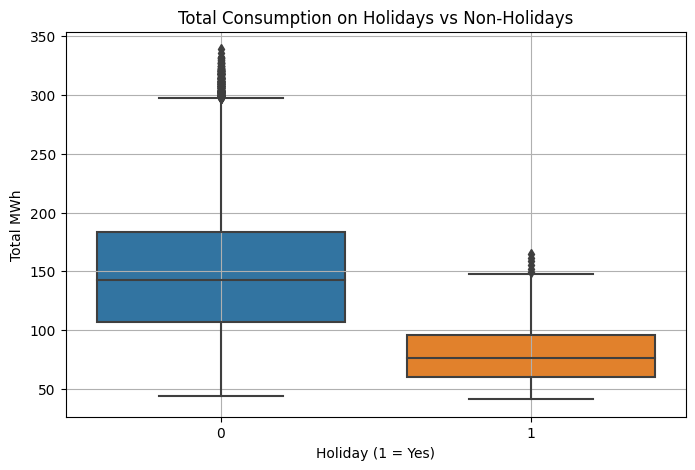

In [6]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(x=df['holiday'], y=df['total_consumption'])
plt.title("Total Consumption on Holidays vs Non-Holidays")
plt.xlabel("Holiday (1 = Yes)")
plt.ylabel("Total MWh")
plt.grid(True)
plt.show()


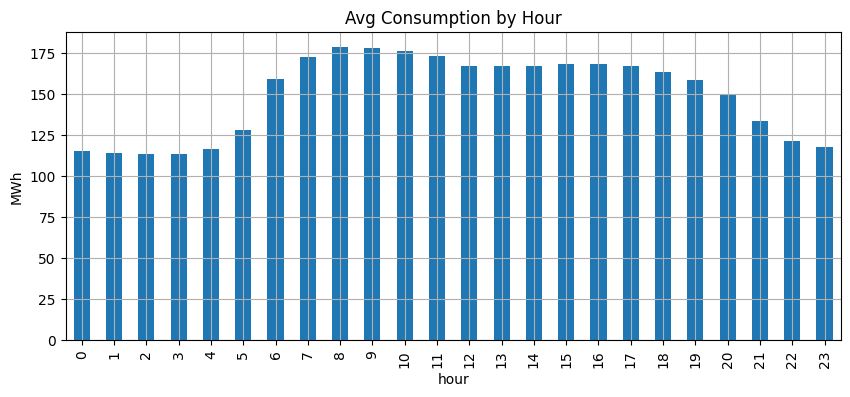

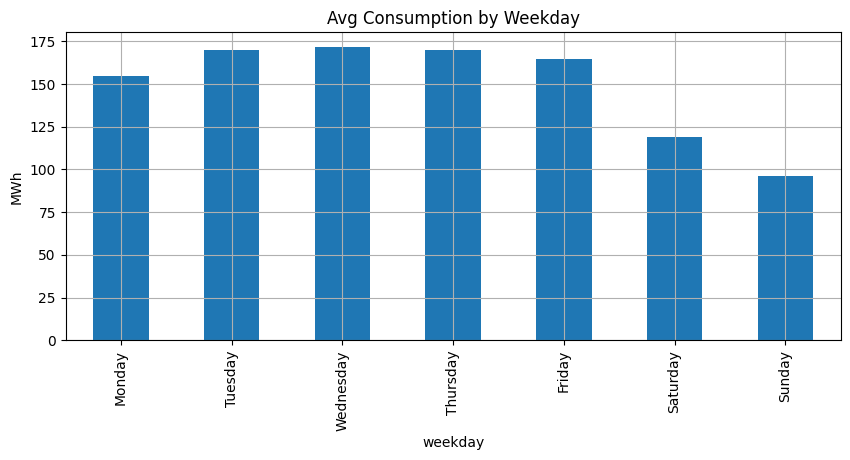

In [7]:
df['hour'] = df.index.hour
df['weekday'] = df.index.day_name()

# Hourly Avg
df.groupby('hour')['total_consumption'].mean().plot(kind='bar', figsize=(10, 4), title="Avg Consumption by Hour")
plt.ylabel("MWh")
plt.grid(True)
plt.show()

# Weekday Avg
df.groupby('weekday')['total_consumption'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).plot(kind='bar', figsize=(10, 4), title="Avg Consumption by Weekday")
plt.ylabel("MWh")
plt.grid(True)
plt.show()


<ipython-input-8-3cd032d577db>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_consumption = df['total_consumption'].resample('M').sum()


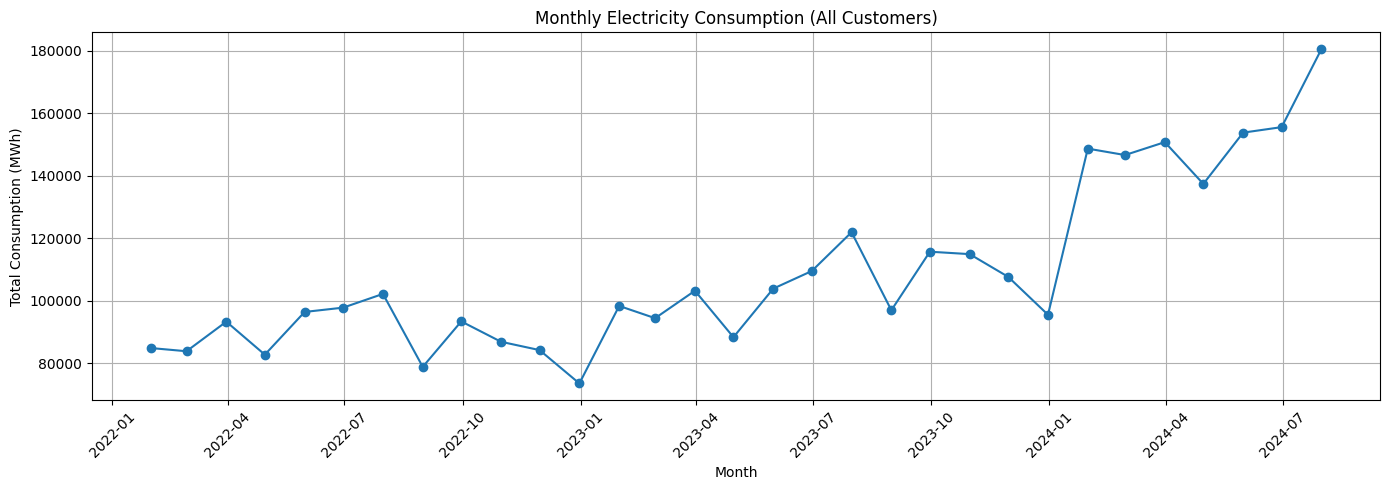

In [8]:
import matplotlib.pyplot as plt

# Resample to monthly totals
monthly_consumption = df['total_consumption'].resample('M').sum()

# Plot the line chart
plt.figure(figsize=(14, 5))
plt.plot(monthly_consumption.index, monthly_consumption.values, marker='o', linestyle='-')
plt.title("Monthly Electricity Consumption (All Customers)")
plt.xlabel("Month")
plt.ylabel("Total Consumption (MWh)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['total_consumption'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] < 0.05:
    print("✅ Data is stationary")
else:
    print("🚫 Data is NOT stationary")





ADF Statistic: -12.060378878664643
p-value: 2.4773439834624027e-22
✅ Data is stationary


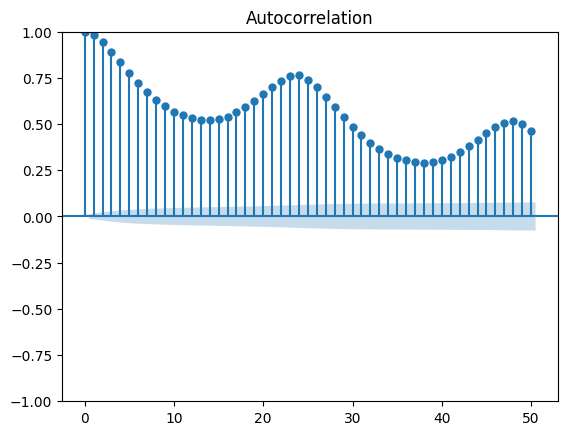

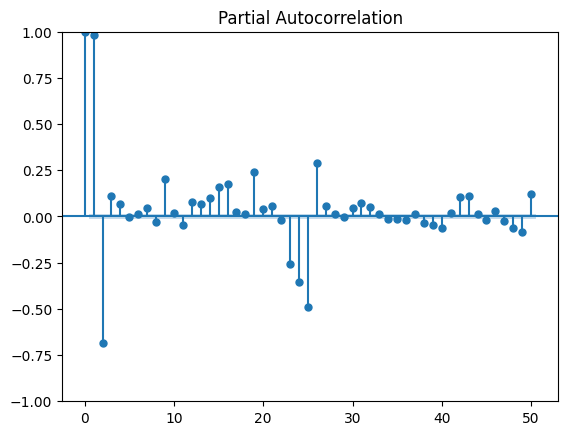

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['total_consumption'].dropna(), lags=50)
plot_pacf(df['total_consumption'].dropna(), lags=50)
plt.show()


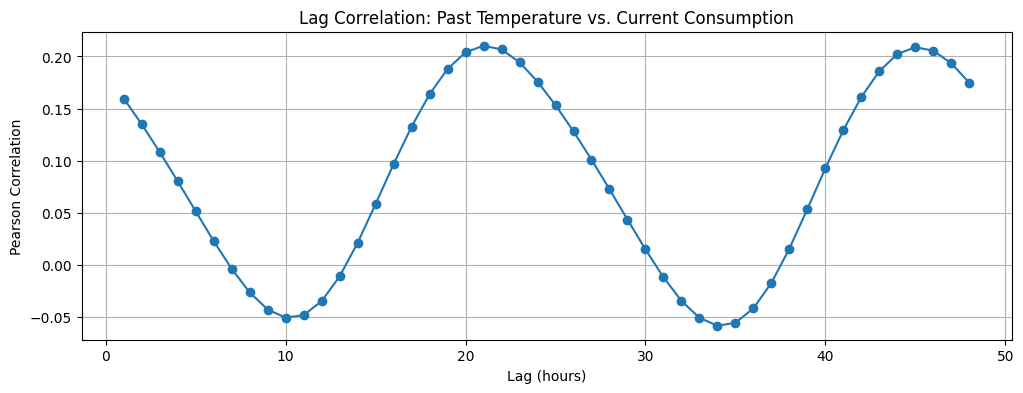

In [15]:
# Lag correlation calculation
max_lag = 48  # Try 48 hours
lag_corrs = []
for lag in range(1, max_lag + 1):
    shifted_temp = df['temp'].shift(lag)
    corr = df['total_consumption'].corr(shifted_temp)
    lag_corrs.append(corr)

# Plot lag correlations
plt.figure(figsize=(12, 4))
plt.plot(range(1, max_lag + 1), lag_corrs, marker='o')
plt.title("Lag Correlation: Past Temperature vs. Current Consumption")
plt.xlabel("Lag (hours)")
plt.ylabel("Pearson Correlation")
plt.grid()
plt.show()


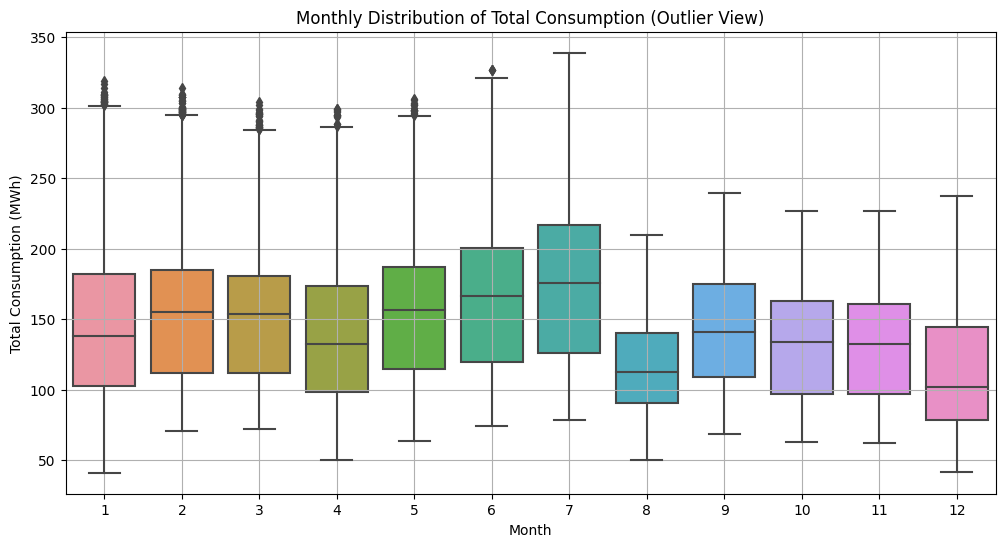

In [16]:
plt.figure(figsize=(12, 6))
df['month'] = df.index.month
sns.boxplot(x='month', y='total_consumption', data=df)
plt.xlabel('Month')
plt.ylabel('Total Consumption (MWh)')
plt.title('Monthly Distribution of Total Consumption (Outlier View)')
plt.grid(True)
plt.show()


In [17]:
from scipy.stats import zscore

# Calculate Z-scores for total consumption
df['zscore'] = zscore(df['total_consumption'])
df_outliers = df[np.abs(df['zscore']) > 3]  # Values with z-score > 3 or < -3 are considered outliers

print(f"Outliers detected: {len(df_outliers)}")



Outliers detected: 35


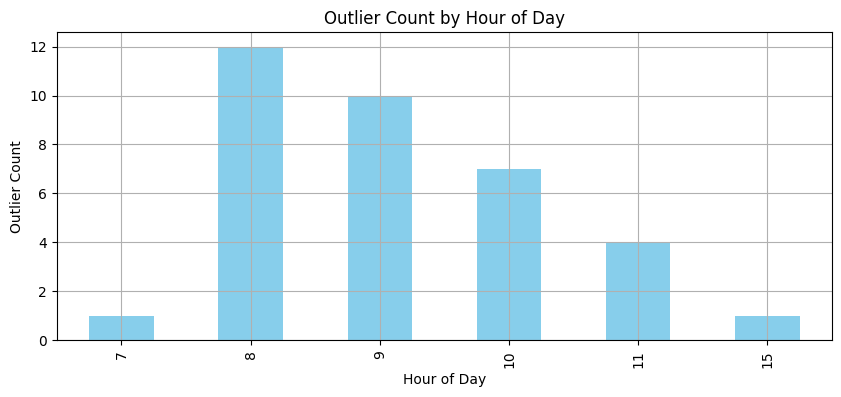

In [24]:
df_outliers.loc[:, 'hour'] = df_outliers.index.hour

outlier_hour_dist = df_outliers['hour'].value_counts().sort_index()

plt.figure(figsize=(10, 4))
outlier_hour_dist.plot(kind='bar', color='skyblue')
plt.title('Outlier Count by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Outlier Count')
plt.grid(True)
plt.show()


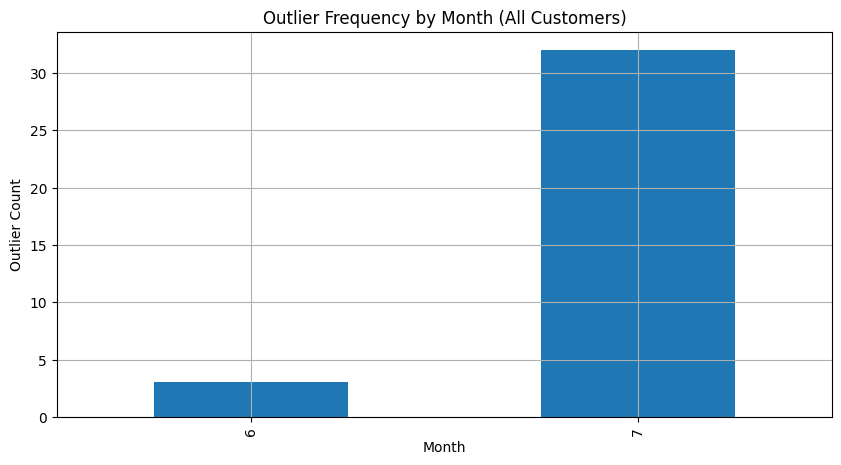

In [18]:
    df['month'] = df.index.month
outlier_months = df_outliers['month'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
outlier_months.plot(kind='bar')
plt.title("Outlier Frequency by Month (All Customers)")
plt.xlabel("Month")
plt.ylabel("Outlier Count")
plt.grid(True)
plt.show()


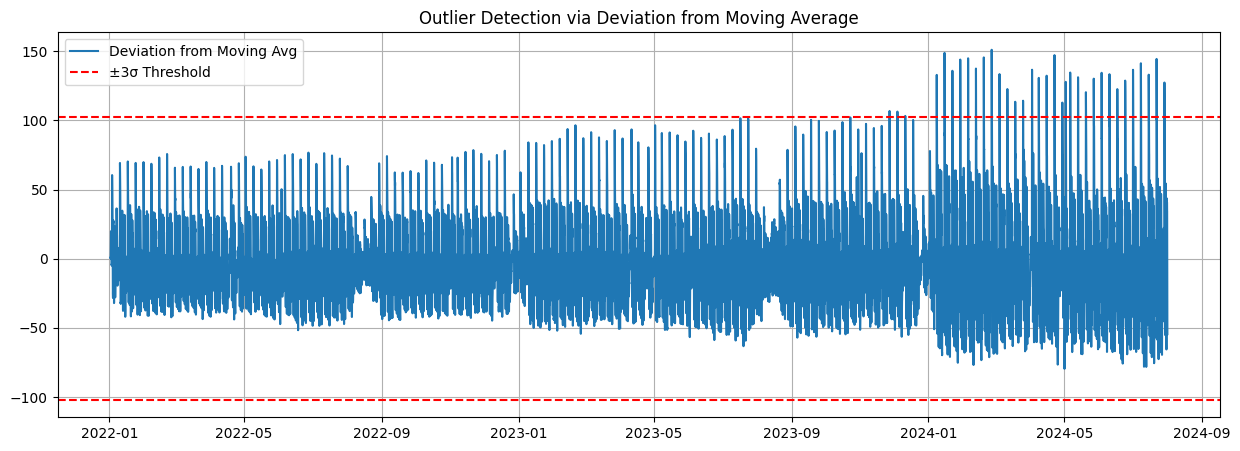

In [19]:
df['moving_avg'] = df['total_consumption'].rolling(window=24).mean()
df['deviation'] = df['total_consumption'] - df['moving_avg']

plt.figure(figsize=(15,5))
plt.plot(df.index, df['deviation'], label='Deviation from Moving Avg')
plt.axhline(df['deviation'].mean() + 3*df['deviation'].std(), color='red', linestyle='--', label='±3σ Threshold')
plt.axhline(df['deviation'].mean() - 3*df['deviation'].std(), color='red', linestyle='--')
plt.legend()
plt.grid()
plt.title("Outlier Detection via Deviation from Moving Average")
plt.show()


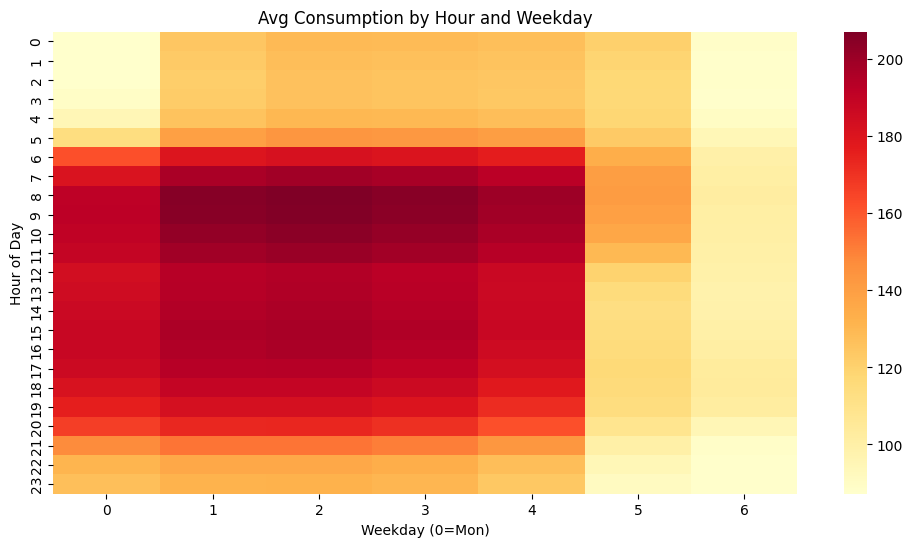

In [21]:
df['weekday'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday
pivot = df.pivot_table(index='hour', columns='weekday', values='total_consumption', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='YlOrRd', annot=False)
plt.title('Avg Consumption by Hour and Weekday')
plt.xlabel('Weekday (0=Mon)')
plt.ylabel('Hour of Day')
plt.show()


<ipython-input-22-d5c026a73aa8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  focus['rolling_mean'] = focus['total_consumption'].rolling(24).mean()


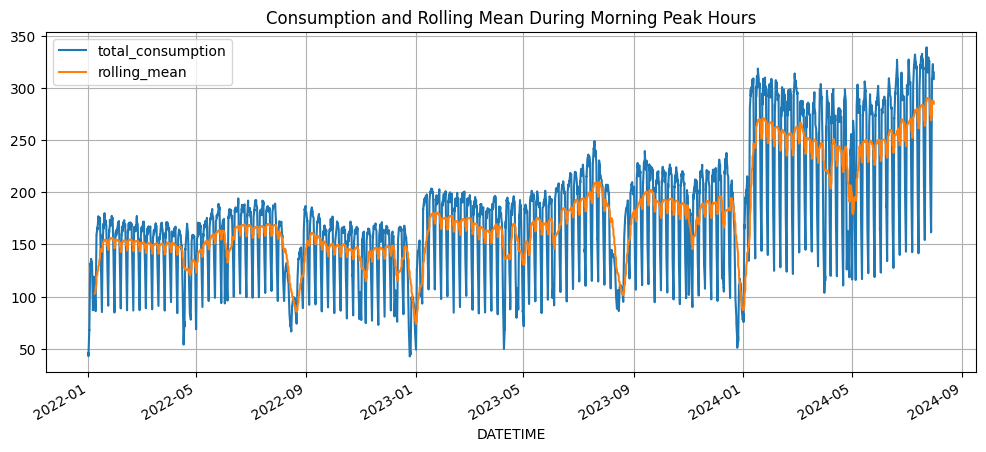

In [22]:
focus = df[df.index.hour.isin([8, 9, 10])]
focus['rolling_mean'] = focus['total_consumption'].rolling(24).mean()
focus[['total_consumption', 'rolling_mean']].plot(figsize=(12,5))
plt.title("Consumption and Rolling Mean During Morning Peak Hours")
plt.grid()
plt.show()


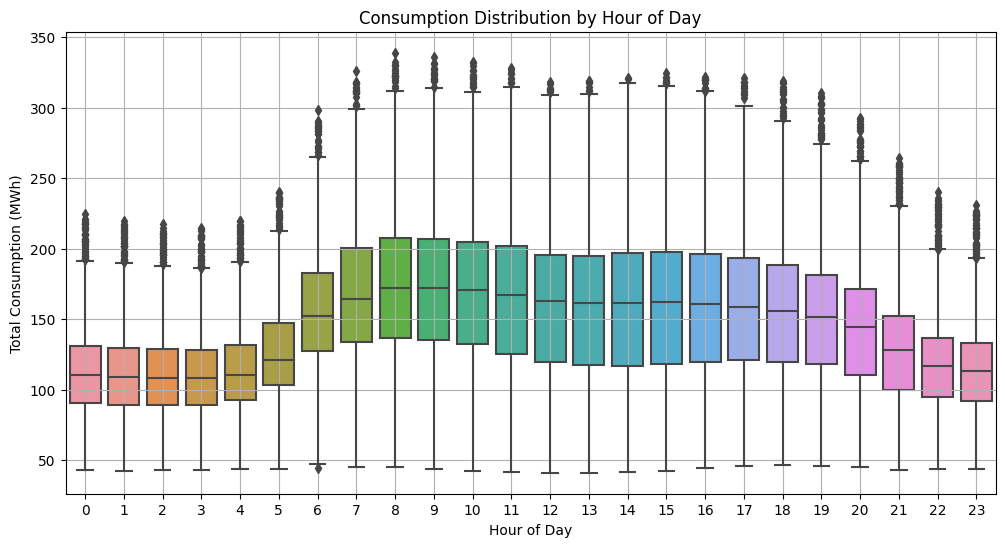

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='total_consumption', data=df)
plt.title('Consumption Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Consumption (MWh)')
plt.grid()
plt.show()
